<p><font size="6" color='grey'> <b>
Machine Learning
</b></font> </br></p> 
<p><font size="5" color='grey'> <b>
Time Series Analysis  - Recurrent Neural Network & LSTM - Australian Beer Production
</b></font> </br></p> 

---

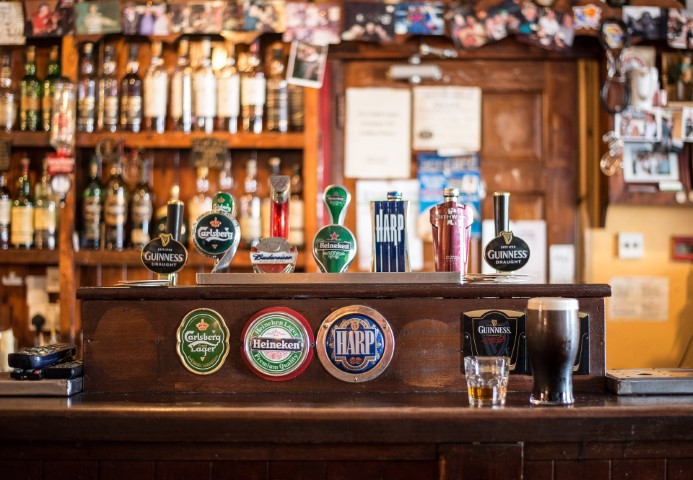

Bild von <a href="https://pixabay.com/de/users/christian_birkholz-76800/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=209148">Christian_Birkholz</a> auf <a href="https://pixabay.com/de//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=image&amp;utm_content=209148">Pixabay</a>

# **1 <font color='orange'>|</font> Understand**
---

<p><font color='black' size="5">
Warnungen ausschalten
</font></p>

In [1]:
import warnings
warnings.filterwarnings('ignore')

<p><font color='black' size="5">
Anwendungsfall
</font></p>

---   

Monatliche australische Bierproduktion 1956 - 1995.



[Info](https://www.kaggle.com/datasets/sergiomora823/monthly-beer-production)

[DataSet](https://www.kaggle.com/datasets/sergiomora823/monthly-beer-production)





In [2]:
import pandas as pd
import numpy as np

In [4]:
data=pd.read_csv('/content/monthly-beer-production-in-austr.csv')

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [ ]:
data.columns = ['YearMonth', 'Production']

In [7]:
data.YearMonth = pd.to_datetime(data.YearMonth)
data.set_index('YearMonth', inplace=True)
data.index = pd.to_datetime(data.index) # ??
data.head(-5)

,Production
YearMonth,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1994-11-01,190.0
1994-12-01,182.0
1995-01-01,138.0


<p><font color='black' size="5">
EDA (Exploratory Data Analysis)   
</font></p>

<p><font color='black' size="4">
Zeitreihe Bierproduktion
</font></p>

In [8]:
import plotly.express as px
fig = px.line(data, title="Australien Beer Production", width=1200, height=500)
fig.show()

In [9]:
%%capture
try:
  from scalecast.Forecaster import Forecaster 
except:
  !pip install -q scalecast
  from scalecast.Forecaster import Forecaster

In [11]:
from scalecast.Forecaster import Forecaster
f = Forecaster(
    y=data['Production'],
    current_dates=data.index,
    test_length = 24,
    future_dates = 12,
    cis = True,
)

<p><font color='black' size="4">
Decomposition der Zeitreihen
</font></p>

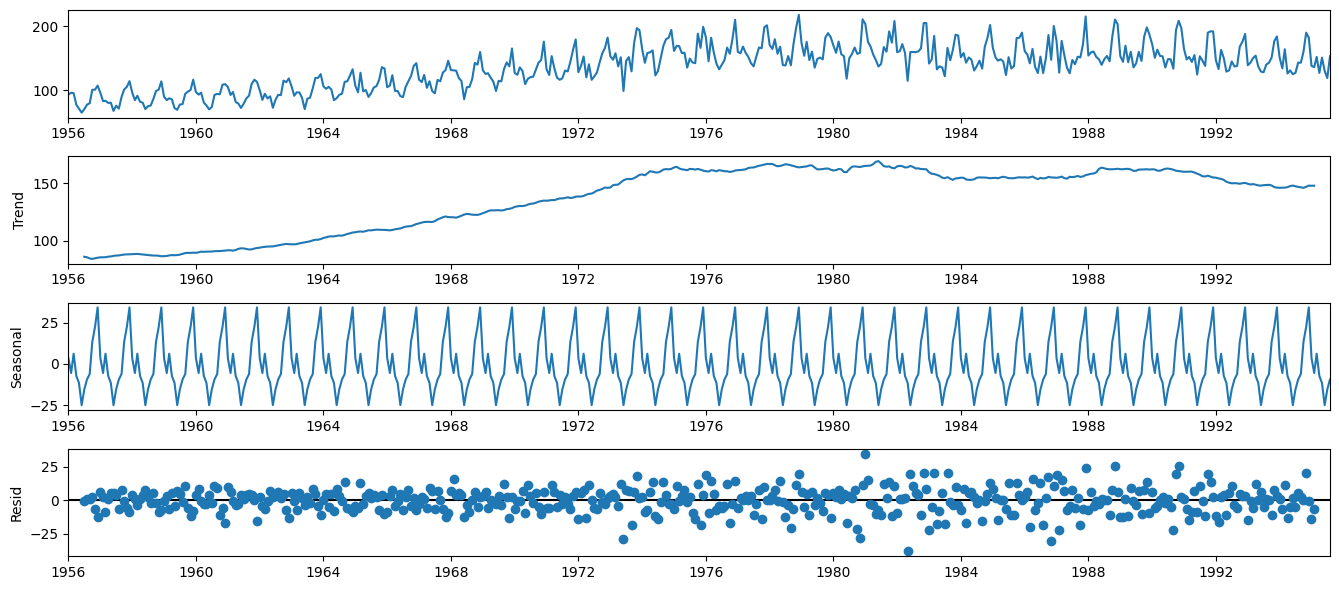

In [14]:
plt.rc("figure",figsize=(13.5,6))
f.seasonal_decompose().plot()
plt.show()

In [ ]:
del f

# **2 <font color='orange'>|</font> Prepare**
---


<p><font color='black' size="5">
Übergreifende Parameter
</font></p

In [15]:
epochs_ = 15
num_features_ = 1
look_back_ = 12
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

In [ ]:
#@title 
#@markdown <p><font size="5" color='grey'> <b> TimeseriesGenerator</b></font> </br></p> 

# series_cnt = data.shape[0]
# test_size = 0.10
# test_cnt = int(series_cnt * test_size)
# train_cnt = series_cnt - test_cnt
# series_cnt, train_cnt, test_cnt
# -------------------
# train=data['Production'].iloc[:-test_cnt].copy()
# test=data['Production'].iloc[train_cnt:].copy()
# -----------------
# train = train.to_numpy().flatten() 
# test = test.to_numpy().flatten() 
# -----------------
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# look_back_ = 12       # Länge jedes Samples, das zum Trainieren des Netzwerks verwendet wird
# n_features = 1       # stellt die Anzahl der ausgegebenen Unterserien pro Batch dar
# generator = TimeseriesGenerator(train, train, length=look_back_, batch_size=n_features)


In [17]:
#@title 
#@markdown <p><font size="5" color='grey'> <b> Function create_dataset  alternativ zu TimeseriesGenerator</b></font> </br></p> 
def create_dataset(x, y, time_step = 12):
  xs,ys = [] , []
  for i in range(len(x) - time_step):
    v = x.iloc[i:(i + time_step)].values
    xs.append(v)
    ys.append(y.iloc[i + time_step])
  return np.array(xs), np.array(ys)

In [18]:
x, y = create_dataset(data, data, look_back_)

# **3 <font color='orange'>|</font> Modeling**
---

<p><font color='black' size="5">
Train-Test-Split
</font></p>

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test, target_train, target_test = train_test_split(x, y, test_size=0.05, shuffle=False)
data_train.shape, data_test.shape, target_train.shape, target_test.shape

In [24]:
del x, y

<p><font color='black' size="5">
Modellierung eines Neuronalen Netzes
</font></p>

[Core layers](https://keras.io/api/layers/core_layers/)    
[Recurrent layers](https://keras.io/api/layers/recurrent_layers/)   
[Layer activation functions](https://keras.io/api/layers/activations/)   


In [25]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

[Info](https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/)


+ return_sequences = True
+ return_state = True

In [26]:
model = Sequential(name="Beer_Production_Forecast")
model.add(Input(shape=(look_back_, num_features_)))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dense(1))

In [27]:
model.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

<p><font color='black' size="5">
Einfaches Layer-Diagramm
</font></p>

In [28]:
model.summary()

Model: "Beer_Production_Forecast"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 329,857
Trainable params: 329,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

<p><font color='black' size="5">
Training
</font></p>


**Callback**

Ein Callback ist ein Objekt, das Aktionen in verschiedenen Stadien des Trainings ausführen kann (z. B. zu Beginn oder am Ende einer Epoche, vor oder nach einem einzelnen Stapel usw.).

Sie können Rückrufe verwenden, um:

+ Schreiben Sie nach jedem Trainingsstapel TensorBoard-Protokolle, um Ihre Metriken zu überwachen
+ Speichern Sie Ihr Modell regelmäßig auf der Festplatte
+ Machen Sie frühzeitig Schluss
+ Verschaffen Sie sich während des Trainings einen Überblick über interne Zustände und Statistiken eines Modells
+ ...

In [29]:
# callback für learning-rate-scheduler
epochs_decr = int(epochs_* 0.15)
def scheduler(epoch, lr):
  lr_new = lr
  if epoch >= epochs_decr:
    lr_new *= tf.math.exp(-0.1)
  return lr_new

learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=True)

In [ ]:
%%time
history = model.fit(data_train, target_train, epochs=epochs_, callbacks=[learning_rate_callback])

In [31]:
#@title 
#@markdown <p><font size="5" color='grey'> <b> Loss Entwicklung</b></font> </br></p> 
my_loss= model.history.history['loss']
my_loss = pd.DataFrame(my_loss)
my_loss.index.names = ['Epoche']
my_loss.columns = ['loss']
fig = px.line(my_loss, title="Mean Absolut Error der Epochen", width=1200, height=500)
fig.show()

# **4 <font color='orange'>|</font> Evaluate**
---

<p><font color='black' size="5">
Prognose Train
</font></p>

In [32]:
target_train_pred = model.predict(data_train)

14/14 [==============================] - 2s 94ms/step


<p><font color='black' size="5">
Bestimmheitsmass Train
</font></p>

In [33]:
from sklearn.metrics import r2_score
r2 = r2_score(target_train, target_train_pred)  
print(f'Bestimmtheitsmass -- Train --: {r2:5.2f}' )

Bestimmtheitsmass -- Train --:  0.90


<p><font color='black' size="5">
Prognose Test
</font></p>

In [34]:
# Die letzten x Wochen (look_back) sind der Aufsetzpunkt für die erste Prognose
target_test_pred = target_train[-look_back_:]

In [35]:
# Anpassung Dimensionen, wie von RNN/LSTM erwartet (analog TimeseriesGeneration, siehe oben)
current_batch = target_test_pred.reshape((1,look_back_, num_features_))

In [ ]:
# rollierender Forecast
for i in range(len(target_test)):    
    pred = model.predict(current_batch)[0]
    target_test_pred = np.append(target_test_pred, float(pred))
    current_batch = target_test_pred[-look_back_:].reshape((1,look_back_, 1))

In [37]:
# Löschen der look-back Wochen, die aus den Trainingsdaten, die für die 1. Prognose übernommen wurden (siehe oben)
target_test_pred = target_test_pred[look_back_:]

<p><font color='black' size="5">
Graphische Aufbereitung der Ergebnisse
</font></p>

In [38]:
result = data[-len(target_test):].copy()
result = result.reset_index()

In [39]:
result['LSTM'] = pd.DataFrame(target_test_pred)

In [40]:
import plotly.express as px
fig = px.line(result, x='YearMonth', y=['Production', 'LSTM'], title="Australien Beer Production - Real Production vs. Forecast", width=1200, height=500)
fig.show()

# **5 <font color='orange'>|</font> Deploy**
---

# **A <font color='orange'>|</font> SARIMA**
---

[SARIMA](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)


**trend**   
Parameter, der das deterministische Trendpolynom steuert
. Kann als Zeichenkette angegeben werden, wobei „c“ eine Konstante angibt (dh eine Komponente vom Grad Null des Trendpolynoms), „t“ einen linearen Trend mit der Zeit angibt und „ct“ beides ist. Kann auch als Iterable angegeben werden, das die einzubeziehenden Polynomexponenten ungleich null in aufsteigender Reihenfolge definiert. Beispielsweise bezeichnet [1,1,0,1].
. Standardmäßig ist keine Trendkomponente enthalten.

**order**   
Die (p,d,q)-Ordnung des Modells für die Anzahl der AR-Parameter, Differenzen und MA-Parameter. d muss eine ganze Zahl sein, die die Integrationsreihenfolge des Prozesses angibt, während p und q entweder ganze Zahlen sein können, die die AR- und MA-Reihenfolgen angeben (so dass alle Verzögerungen bis zu diesen Reihenfolgen enthalten sind) oder Iterables, die spezifische AR und / oder MA angeben Verzögerungen einzubeziehen. Standard ist ein AR(1)-Modell: (1,0,0).

**seasonal_order**   
Die (P,D,Q,s)-Reihenfolge der saisonalen Komponente des Modells für die AR-Parameter, Differenzen, MA-Parameter und Periodizität. D muss eine ganze Zahl sein, die die Integrationsreihenfolge des Prozesses angibt, während P und Q entweder ganze Zahlen sein können, die die AR- und MA-Reihenfolge angeben (so dass alle Verzögerungen bis zu diesen Reihenfolgen enthalten sind) oder andernfalls Iterables, die spezifische AR und / oder MA angeben Verzögerungen einzubeziehen. s ist eine ganze Zahl, die die Periodizität (Anzahl der Saisonperioden) angibt, oft ist es 4 für vierteljährliche Daten oder 12 für monatliche Daten. Standard ist kein saisonaler Effekt.

In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

<p><font color='black' size="5">
Modellbildung, Training, Prognose
</font></p>

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# --- Initalisieung der Variablen 

data_list = data['Production'].values
size = len(data_list) - len(target_test_pred)
data_train_list, data_test_list = data_list[0:size], data_list[size:len(data_list)]
history = [x for x in data_train_list]
predictions = list()

In [ ]:
# --- Modelldefinition & Training

model_sarima = SARIMAX(history, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
model_sarima = model_sarima.fit(disp=0)

In [ ]:
# --- rollierende Prognose ab Zeitpunkt Trainingsende

for t in range(len(data_test_list)):
	output = model_sarima.predict(start=len(history), end=len(history))
	yhat = output[0]
	predictions.append(yhat)
	# obs = data_test_list[t]		# yhat anstelle obs in Zeile 15
	history.append(yhat)

<p><font color='black' size="5">
Graphische Aufbereitung der Ergebnisse
</font></p>

In [ ]:
RollBack =  data[size:len(data)]
RollBack['SARIMA']= predictions
RollBack.head()

In [ ]:
fig = px.line(RollBack, title="Australien Beer Production - Real Production vs Forecast", width=1200, height=500)
fig.show()

In [ ]:
RollBack['LSTM']= target_test_pred
RollBack.head()

In [ ]:
fig = px.line(RollBack, title="Australien Beer Production - Real Production vs Forecast", width=1200, height=500)
fig.show()

In [ ]:
#@title 
#@markdown <p><font size="5" color='grey'> <b> Bestimmung der besten Parameter

# [Quelle](https://medium.com/towards-data-science/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d)

# import itertools 
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter for SARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# param_search = pd.DataFrame(columns=['param', 'param_seasonal', 'aic'])

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = SARIMAX(history,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
#             results = mod.fit()
#             # print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
#             param_search = param_search.append({'param':param,'seasonal':param_seasonal ,'AIC': results.aic}, ignore_index = True)
#         except: 
#             continue

# results.plot_diagnostics(figsize=(18, 8))
# plt.show()

In [ ]:
#@title 
#@markdown <p><font size="5" color='grey'> <b> alte Version Modelldefinition, Training & Prediction</b></font> </br></p> 
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# X = data['Production'].values
# size = len(X) - len(test_pred)
# train, test = X[0:size], X[size:len(X)]
# history = [x for x in train]
# predictions = list()
# for t in range(len(test)):
# 	print("Iteration: ", t)
# 	model = SARIMAX(history, trend='n', order=(1,1,1), seasonal_order=(2,0,2,12))
# 	model_fit = model.fit(disp=0)
# 	output = model_fit.forecast()
# 	yhat = output[0]
# 	predictions.append(yhat)
# 	obs = test[t]
# 	history.append(obs)